# Vehicle routing problem als mip

In [1]:
import mip
import random
import math
import matplotlib.pylab as plt  # für Grafikausgabe
import numpy as np  # Standard-Bibliothek für wissenschaftliches Rechnen, könnte hier vermieden werden

Using Python-MIP package version 1.8.1


## Zufallsinstanz

wir erzeugen eine Zufallsinstanz mit euklidischen Distanzen

In [2]:
n=15 # Anzahl Kunden
k=3  # Anzahl Lieferwagen
q=10 # Kapazität der Lieferwagen

C=range(1,n+1) # Menge der Kunden
V=range(n+1)   # Menge Kunden+Depot, das Depot hat Nr 0
# Wir platzieren die Kunden und das Depot zufällig in das [0,1]*[0,1]-Quadrat
Cpos=np.array([(random.random(),random.random()) for _ in V])
# die Kantenmenge
E=[(u,v) for u in range(n+1) for v in range(n+1) if u!=v]
# Zufallsnachfragen
d=[random.randint(1,3) for _ in V]

Text(0.5, 1.0, 'Kunden in blau, Depot in rot, euklidische Distanzen')

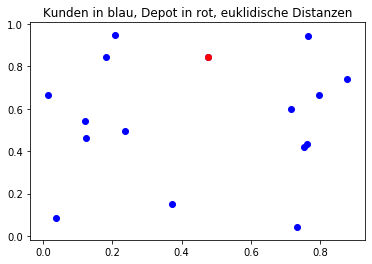

In [3]:
plt.scatter(Cpos[:,0],Cpos[:,1],c='b')
plt.scatter([Cpos[0,0]],[Cpos[0,1]],c='r')
plt.title('Kunden in blau, Depot in rot, euklidische Distanzen')

## Das mip

In [4]:
m=mip.Model()

In [5]:
# die Variablen
x=[m.add_var(var_type=mip.BINARY) for _ in E]
y=[m.add_var(lb=0,ub=q) for _ in V]

In [6]:
def dist(e):
    """berechnet die Euklidische Länge der Kante e=(u,v)"""
    u,v=e
    return math.sqrt((Cpos[u,0]-Cpos[v,0])**2+(Cpos[u,1]-Cpos[v,1])**2)

In [7]:
# Zielfunktion
m.objective=mip.minimize(mip.xsum(dist(e)*x[i] for i,e in enumerate(E)))

In [9]:
# Hilfsfunktionen: Indizies der ein- bzw ausgehenden Kanten bei einer Ecke v
def ingoing_edges(v):
    return [i for i,e in enumerate(E) if e[1]==v]

def outgoing_edges(v):
    return [i for i,e in enumerate(E) if e[0]==v]

In [10]:
# Höchstens k Lieferwagen starten am Depot
m+=mip.xsum(x[i] for i in outgoing_edges(0))<=k

In [11]:
# Jeder Kunde muss bedient werden
for v in C:
    m+=mip.xsum(x[i] for i in ingoing_edges(v))==1

In [12]:
# Keine Teleportation der Lieferwagen
for v in V:
    m+=mip.xsum(x[i] for i in ingoing_edges(v))-mip.xsum(x[i] for i in outgoing_edges(v))==0

In [13]:
# Auslastung der Lieferwagen erhöht sich, wenn sie am Kunden ankommen
for i,e in enumerate(E):
    u,v=e
    if u!=0:  # Bedingung wird nicht für vom Depot ausgehender Kante erzwungen
        m+=y[u]+d[u]-y[v]<= (1-x[i])*q

In [ ]:
m.optimize()  # kann länger dauern....